## Final Project Submission

Please fill out:
* Student name: Jason Lombino
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:

In [1]:
import sqlite3
import pandas as pd
import gzip as gz
import zipfile
import os
import numpy as np
import seaborn as sns

pd.options.mode.chained_assignment = None

In [2]:
with gz.open('zippedData/tn.movie_budgets.csv.gz') as f:
    tn_movie_budgets = pd.read_csv(f)

if not os.path.exists('zippedData/im.db'):
    with zipfile.ZipFile('zippedData/im.db.zip') as my_zip:
        zipfile.ZipFile.extractall(my_zip,path='zippedData/')

im_db = sqlite3.connect('zippedData/im.db')
im_db_basics = pd.read_sql("""SELECT * FROM movie_basics""",im_db)

In [3]:
tn_movie_budgets['year'] = tn_movie_budgets['release_date'].str[-4:]
tn_movie_budgets['month'] = tn_movie_budgets['release_date'].str[:3]
tn_movie_budgets['clean_budget'] = tn_movie_budgets['production_budget'].str.replace('$','')
tn_movie_budgets['clean_budget'] = tn_movie_budgets['clean_budget'].str.replace(',','').astype(int)
tn_movie_budgets['clean_domestic'] = tn_movie_budgets['domestic_gross'].str.replace('$','')
tn_movie_budgets['clean_domestic'] = tn_movie_budgets['clean_domestic'].str.replace(',','').astype(int)
tn_movie_budgets['clean_worldwide'] = tn_movie_budgets['worldwide_gross'].str.replace('$','')
tn_movie_budgets['clean_worldwide'] = tn_movie_budgets['clean_worldwide'].str.replace(',','').astype(int)
tn_movie_budgets['clean_foreign'] = tn_movie_budgets['clean_worldwide'] - tn_movie_budgets['clean_domestic']
tn_movie_budgets.rename({'movie':'title'},axis=1,inplace=True)

In [4]:
def get_season(month):
    if month in ['Dec','Jan','Feb']:
        return 'Winter'
    elif month in ['Mar','Apr','May']:
        return 'Spring'
    elif month in ['Jun','Jul','Aug']:
        return 'Summer'
    else:
        return 'Autumn'


In [5]:
tn_cols = ['title','year','month','clean_budget','clean_domestic','clean_foreign','clean_worldwide']
tn = tn_movie_budgets[tn_cols]
tn = tn[tn['year'].astype(int) >= 2000]
tn['roi_%_domestic'] = 100*(tn['clean_domestic'] - tn['clean_budget']) / tn['clean_budget']
tn['roi_%_worldwide'] = 100*(tn['clean_worldwide'] - tn['clean_budget']) / tn['clean_budget']
tn['clean_profit'] = tn['clean_worldwide'] - tn['clean_budget']
tn['Season'] = tn['month'].apply(get_season)

In [6]:
im_db_basics.rename({'primary_title':'title'},axis=1,inplace=True)
im_db_cols = ['title','genres','runtime_minutes']
im_db_filtered = im_db_basics[im_db_cols]
combined_financial = im_db_filtered.merge(tn,on = 'title',how = 'inner')
combined_financial = combined_financial.drop_duplicates(subset = 'title', keep='first')


In [7]:
genre_set = set()
genre_df = combined_financial['genres'].dropna()
for genres in genre_df.values:
    genre_list = genres.split(',')
    new_genre_set = set(genre_list)
    genre_set = genre_set.union(new_genre_set)
genre_set = sorted(list(genre_set))

In [8]:
genre_financials = pd.DataFrame()
for genre in genre_set:
    genre_specific_df = combined_financial[combined_financial['genres'].str.contains(genre) == True]
    #print(genre,len(genre_specific_df))
    genre_financials = pd.concat([genre_financials,genre_specific_df['roi_%_worldwide']],axis=1)
genre_financials.columns = genre_set

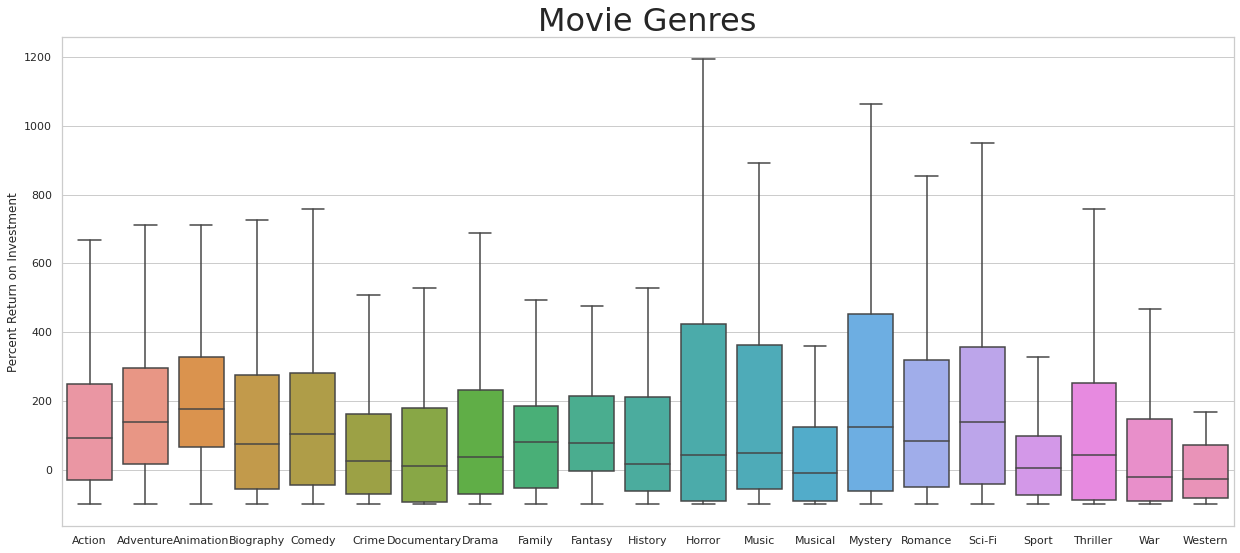

In [9]:

sns.set(rc={'figure.figsize':(21,9)})
sns.set_theme(style='whitegrid');
genre_plot_1 = sns.boxplot(data = genre_financials,showfliers = False)
genre_plot_1.set_ylabel('Percent Return on Investment');
genre_plot_1.set_title('Movie Genres',fontsize=32);

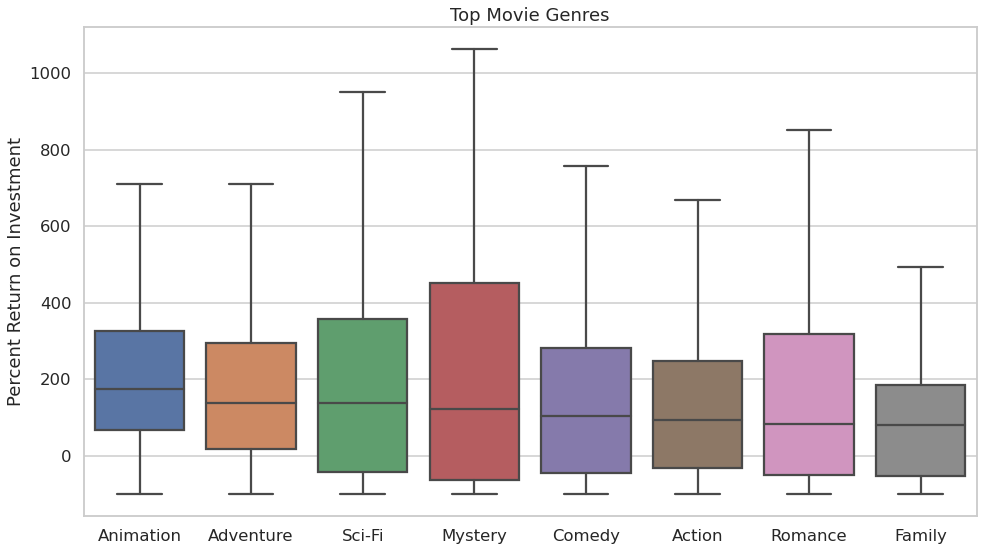

In [10]:
top_genre_financials = genre_financials[genre_financials.median().sort_values(ascending=False).index[:8]]
sns.set(rc={'figure.figsize':(16,9)})
sns.set_theme(style='whitegrid',context='talk');
genre_plot_2 = sns.boxplot(data = top_genre_financials,showfliers = False)
genre_plot_2.set_ylabel('Percent Return on Investment');
genre_plot_2.set_title('Top Movie Genres');

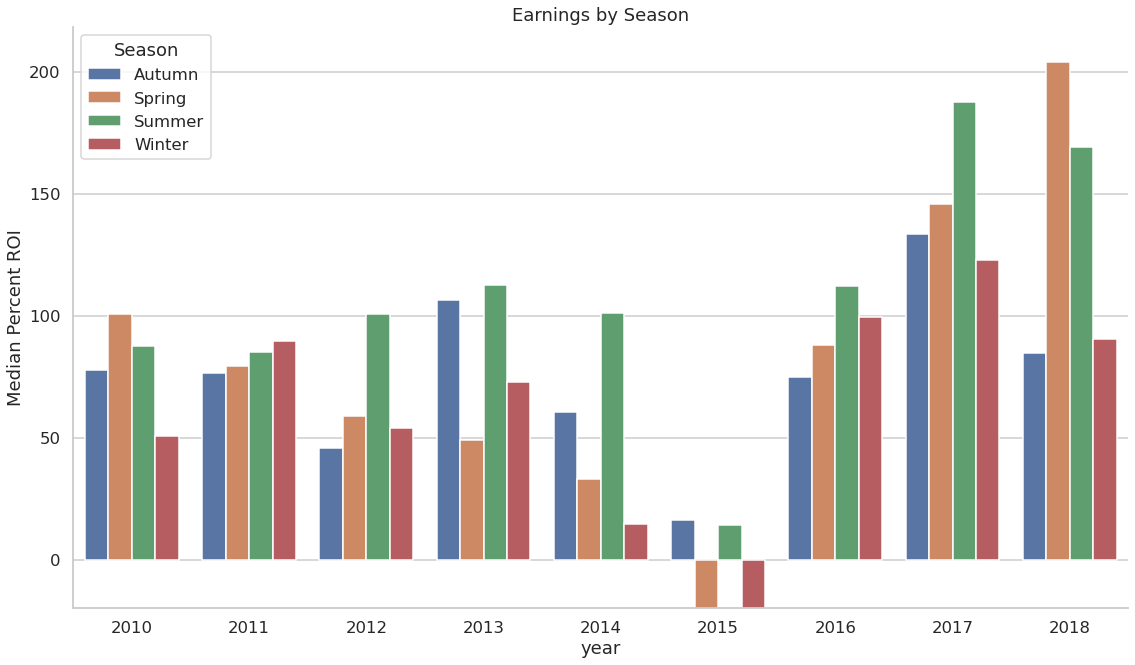

In [11]:
low_year, high_year = (2010,2019)
season_years = combined_financial[(combined_financial['year'].astype(int) >= low_year) & (combined_financial['year'].astype(int) < high_year)]

season_financial = season_years.groupby(['year','Season']).agg(median_earning = ('roi_%_worldwide','median'))
season_financial = season_financial.reset_index()
sns.set_theme(style='whitegrid',context='talk')
season_year_plot = sns.catplot(data = season_financial,x='year',y='median_earning',hue='Season',kind='bar',height = 9,aspect=(16/9),legend_out=False)
season_year_plot.set(ylim = (-20,None),ylabel = "Median Percent ROI",title = 'Earnings by Season');


Text(0.5, 1.0, 'Return on Investment by Season')

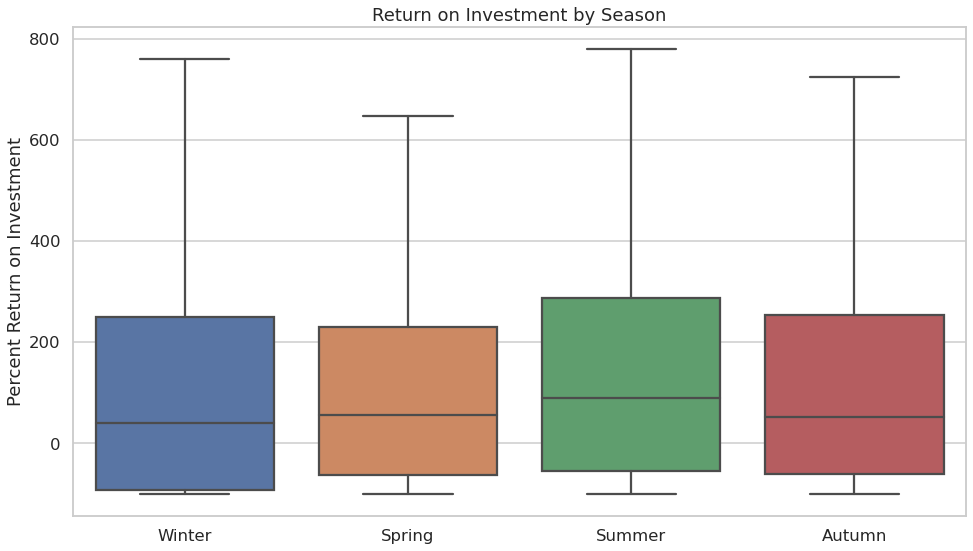

In [12]:
seasons_in_order = ['Winter','Spring','Summer','Autumn']
sns.set(rc={'figure.figsize':(16,9)})
sns.set_theme(style='whitegrid',context='talk');
season_plot = sns.boxplot(data = combined_financial,x='Season',y='roi_%_worldwide',showfliers = False, order = seasons_in_order)
season_plot.set_ylabel('Percent Return on Investment');
season_plot.set_xlabel(None);
season_plot.set_title('Return on Investment by Season')

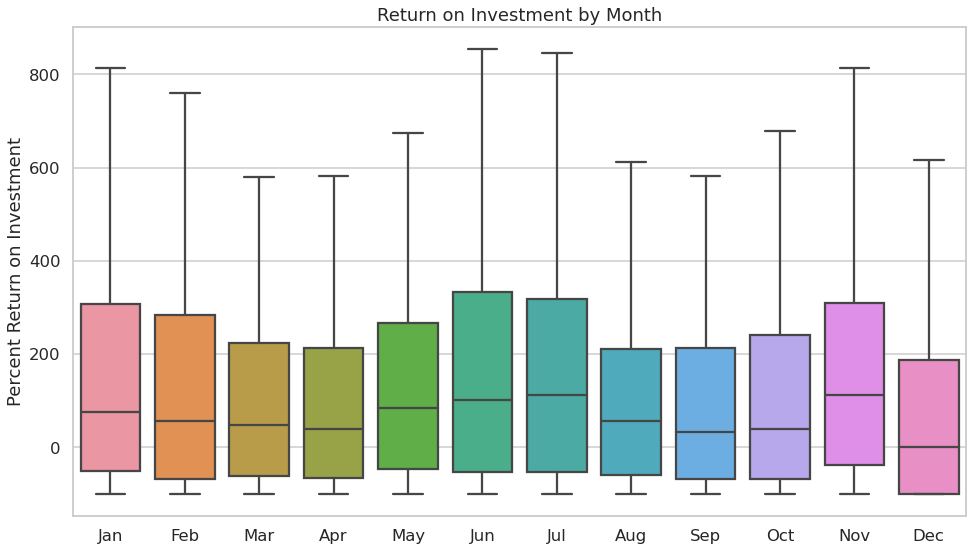

In [13]:
months_in_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
sns.set(rc={'figure.figsize':(16,9)})
sns.set_theme(style='whitegrid',context='talk');
month_plot = sns.boxplot(data = combined_financial,x='month',y='roi_%_worldwide',showfliers = False, order = months_in_order)
month_plot.set_ylabel('Percent Return on Investment');
month_plot.set_xlabel(None);
month_plot.set_title('Return on Investment by Month');

In [14]:
combined_financial.head()

,title,genres,runtime_minutes,year,month,clean_budget,clean_domestic,clean_foreign,clean_worldwide,roi_%_domestic,roi_%_worldwide,clean_profit,Season
0,Foodfight!,"Action,Animation,Comedy",91.0,2012,Dec,45000000,0,73706,73706,-100.000000,-99.836209,-44926294,Winter
1,The Overnight,None,88.0,2015,Jun,200000,1109808,56188,1165996,454.904000,482.998000,965996,Summer
3,On the Road,"Adventure,Drama,Romance",124.0,2013,Mar,25000000,720828,8592474,9313302,-97.116688,-62.746792,-15686698,Spring
9,The Secret Life of Walter Mitty,"Adventure,Comedy,Drama",114.0,2013,Dec,91000000,58236838,129624345,187861183,-36.003475,106.440860,96861183,Winter
10,A Walk Among the Tombstones,"Action,Crime,Drama",114.0,2014,Sep,28000000,26017685,36090902,62108587,-7.079696,121.816382,34108587,Autumn
